In [21]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from environment import Environment
from actor import Actor
from copy import deepcopy
from tqdm import tqdm
from utils import make_simulation_plot, run_environment_simulation, calculate_full_distance

In [22]:
n_samples_train = 500
n_samples_test = 50
n_locations = 5
n_steps = n_locations * 2
max_demand = 10
max_capacity = 50
n_epochs = 150
approximation_level = 10

model_actor = Actor(n_locations)
optimizer = tf.keras.optimizers.legacy.Adam()

env_org = Environment(n_samples_train, n_locations, max_demand, max_capacity)
env_test = Environment(n_samples_test, n_locations, max_demand, max_capacity)

In [23]:
grads_lst = []
losses_train = []
losses_test = []

all_actions_real_train = []
all_actions_real_test = []

all_actions_approximation_train = []
all_actions_approximation_test = []

In [31]:
for _ in tqdm(range(n_epochs)):
    env_train = deepcopy(env_org)
    env_test_process = deepcopy(env_test)
    with tf.GradientTape(persistent=True) as tape:

        actions_approximation_train, actions_real_train = run_environment_simulation(
            env_train, model_actor, n_steps, approximation_level
        )
        actions_approximation_test, actions_real_test = run_environment_simulation(
            env_test_process, model_actor, n_steps, approximation_level
        )

        full_distance_train = calculate_full_distance(tf.convert_to_tensor(actions_approximation_train))
        loss_train = tf.reduce_mean(full_distance_train)
        
        full_distance_test = calculate_full_distance(tf.convert_to_tensor(actions_approximation_test))
        loss_test = tf.reduce_mean(full_distance_test)
        
        losses_train.append(loss_train)
        losses_test.append(loss_test)

    all_actions_approximation_train.append(actions_approximation_train)
    all_actions_approximation_test.append(actions_approximation_test)

    all_actions_real_train.append(actions_real_train) 
    all_actions_real_test.append(actions_real_test)    

    grads = tape.gradient(loss_train, model_actor.trainable_variables)
    grads_and_vars = zip(grads, model_actor.trainable_variables)
    optimizer.apply_gradients(grads_and_vars)
    grads_lst.append(grads)
    break

KeyboardInterrupt: 

In [17]:
full_distance_train

<tf.Tensor: shape=(500,), dtype=float32, numpy=
array([ 3.001894 ,  4.146876 ,  7.1561356,  4.10906  ,  5.1886964,
        8.107601 ,  4.9451814,  3.5577936,  6.684654 ,  7.2804503,
        6.169691 ,  5.2355595,  6.9916573,  4.3227863,  4.6672425,
        4.4475956,  4.683044 ,  5.0804725,  8.503982 ,  6.197903 ,
        6.178664 ,  6.396882 ,  4.62069  ,  6.387162 ,  6.796374 ,
        4.4989033,  4.7846713,  4.105032 ,  5.1899242,  4.726938 ,
        3.8900208,  4.3281846,  5.8610654,  4.6881876,  5.4162827,
        5.259424 ,  4.6419363,  7.4068694,  4.039357 ,  6.5225735,
        8.181021 ,  5.30956  ,  8.552559 ,  5.6968904,  8.471167 ,
       10.380619 ,  9.728812 ,  6.552347 ,  6.373245 ,  4.4234834,
        7.5321507,  7.030259 ,  8.077815 ,  5.425125 ,  3.9524195,
        4.73112  ,  4.523231 ,  6.812064 ,  6.475758 ,  5.0532727,
        4.14387  ,  6.0924788,  6.9387865,  6.229022 ,  7.2084646,
        8.16228  ,  4.883759 ,  9.380806 ,  4.9222503,  2.8060088,
        4.8914

In [12]:
tf.convert_to_tensor(actions_approximation_train).shape

TensorShape([10, 500, 2])

In [127]:
tf_all_actions_approximation_train = tf.convert_to_tensor(all_actions_approximation_train)
tf_all_actions_approximation_test = tf.convert_to_tensor(all_actions_approximation_test)

tf_all_actions_real_train = tf.convert_to_tensor(all_actions_real_train)
tf_all_actions_real_test = tf.convert_to_tensor(all_actions_real_test)
# shape: [n_epochs x n_steps x n_samples x 2]

In [128]:
tf.reduce_mean(tf_all_actions_approximation_train - tf_all_actions_real_train)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.00039661495>

In [129]:
tf.reduce_mean(tf_all_actions_approximation_train - tf_all_actions_real_train)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.00039661495>

In [130]:
def fun(ls, n):
    return [np.mean(ls[i:i+n]) for i in range(0, len(ls) - n)]

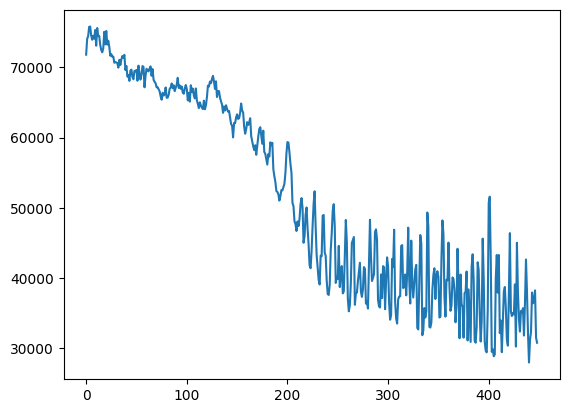

In [167]:
plt.plot(fun(losses_train, 1))
plt.show()

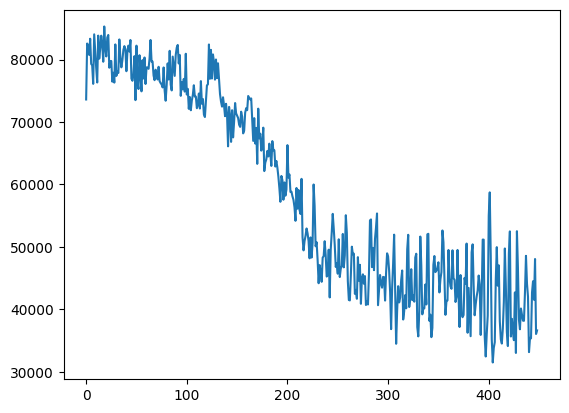

In [166]:
plt.plot(fun(losses_test, 1))
plt.show()
# plt.ylim([0, 250])

In [161]:
sample_id = 87

In [162]:
calculate_loss(tf_all_actions_real_train[0, :, sample_id])

<tf.Tensor: shape=(), dtype=float32, numpy=30009.996>

In [163]:
calculate_loss(tf_all_actions_real_train[-1, :, sample_id])

<tf.Tensor: shape=(), dtype=float32, numpy=34986.816>

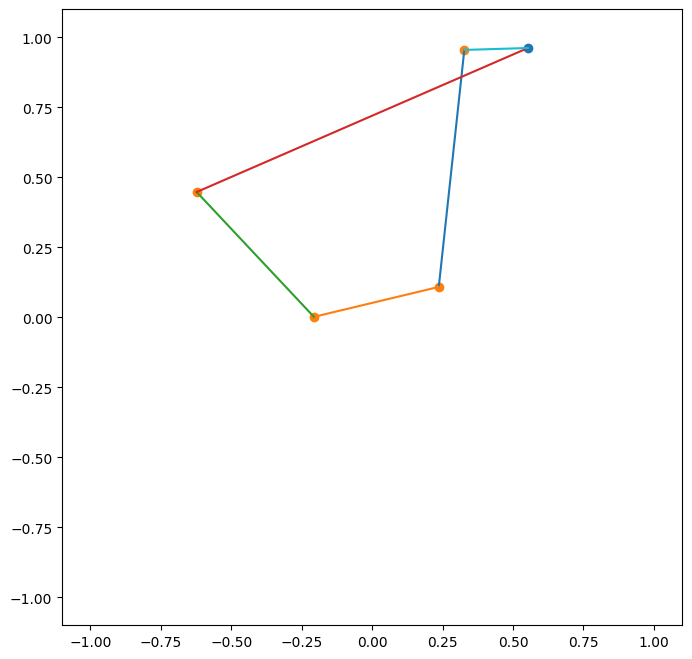

In [164]:
epoch_id = 0

# l1 = calculate_loss(tf_all_actions_real[epoch_id, :, sample_id:sample_id+1, :])
# print(l1.numpy())
make_simulation_plot(env_train.locations[sample_id], tf_all_actions_real_train[epoch_id, :, sample_id])

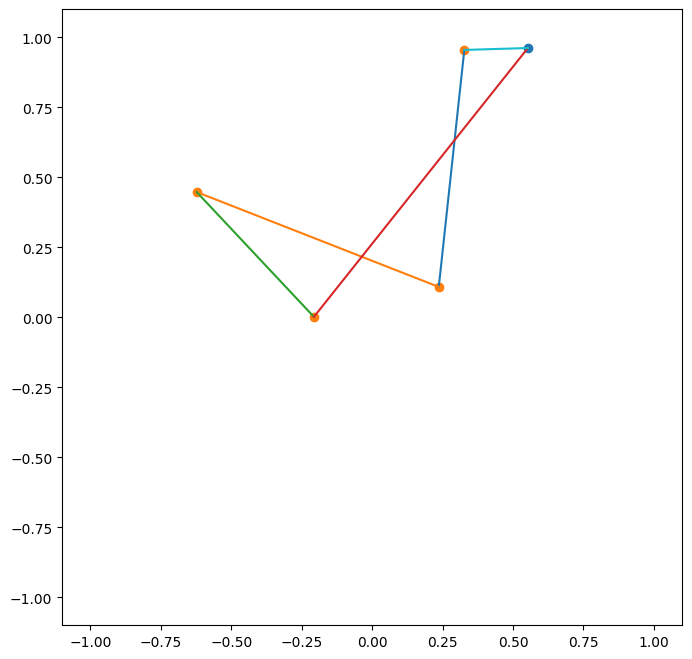

In [165]:
epoch_id = -1

# l1 = calculate_loss(tf_all_actions_real[epoch_id, :, sample_id:sample_id+1, :])
# print(l1.numpy())
make_simulation_plot(env_train.locations[sample_id], tf_all_actions_real_train[epoch_id, :, sample_id])